## 1. Постановка задачи

Нижеприведённая функция вычисляет норму вектора самым очевидным образом.

Недостаток в том, что она не заботится о переполнении (overflow), поскольку хранить в памяти придётся норму вектора в квадрате.

То есть при одинарной точности вместо максимальных $\approx 10^{32}$ мы сможем посчитать лишь норму не больше $\approx 10^{16}$, а при двойной - лишь $\approx 10^{154}$ вместо $\approx 10^{308}$.

In [12]:
from math import sqrt

def naive_norm(vector):
    n = len(vector)
    g = 0.0
    for i in range(n):
        g = g + vector[i] ** 2
    norm = sqrt(g)
    # Будем печатать с 40 знаками после запятой.
    print("{0:.40f}".format(norm))

## 2. Решение

Попробуем исключить этот эффект и вычислять норму без извлечения квадратного корня. 

Для этого можно заметить, что операция сложения Пифагора (Pythagorean addition) $a \bigoplus b = \sqrt{a^2 + b^2}$ обладает свойством коммутативности.   
То есть норма вектора $\|w\| = w_1 \bigoplus w_2  \bigoplus \cdots \bigoplus w_n$

### 2.1 Сначала реализуем $w_1 \bigoplus w_2$

Для этого выберем больший и меньший элементы из пары. Будем проводить операции, не меняющие $w_1 \bigoplus w_2$, так чтобы больший элемент увеличивался, а меньший уменьшался.

Тогда в какой-то момент меньший элемент приблизится к 0, а больший станет значением $w_1 \bigoplus w_2$ (так как эта величина останется неизменной).

In [63]:
def pythag_verbosed(a, b):
    p = max(abs(a), abs(b))
    q = min(abs(a), abs(b))
    print('iteration', '\t\tp\t', '\t\tq\t', '\t\tsqrt(p^2 + q^2)')
    for i in range(3):
        r = (q/p) ** 2
        s = r / (4 + r)
        p = p + 2*s*p
        q = s * q
        print(i+1, '\t\t', p, '\t', q, '\t\t', sqrt(p**2 + q**2))

    print('\n', "{0:.40f}".format(p))

pythag_verbosed(4., 3.)

iteration 		p	 		q	 		sqrt(p^2 + q^2)
1 		 4.986301369863014 	 0.3698630136986301 		 5.0
2 		 4.999999974188253 	 0.0005080526329415358 		 5.0
3 		 5.000000000000001 	 1.311372652397091e-12 		 5.000000000000001

 5.0000000000000008881784197001252323389053


### 2.2 Затем на основе $w_1 \bigoplus w_2$ реализуем $\|w\|$

In [86]:
# Уберём вспомогательную печать
def pythag(a, b):
    p = max(abs(a), abs(b))
    q = min(abs(a), abs(b))
    for i in range(10):
        r = (q/p) ** 2
        p += 2*r*p / (4 + r)
        q *= r / (4 + r)
    return p

def l2_norm(vector):
    norm = 0.0
    for i in range(len(vector)):
        norm = pythag(norm, vector[i])
    print("{0:.40f}".format(norm))

Ещё одна реализация, которая гораздо быстрее предыдущей (идея взята из [[3]](https://github.com/compute-io/l2norm)).

In [85]:
def overflow_free_norm(arr):
    n = len(arr)
    t = 0
    s = 1
    for i in range(n):
        val = arr[i]
        if abs(val) > t:
            r = t / val
            s = 1 + s*r*r
            t = abs(val)
        else:
            r = val / t
            s = s + r*r                    
    print("{0:.40f}".format(t * sqrt(s)))

## 3. Сравнение алгоритмов

### 3.1 По максимально вычисляемым значениям нормы

In [121]:
import numpy as np
from mpmath import norm, nprint

# Идеальное значение нормы с n знаками после запятой.
def ideal_norm_approx(arr, n=40):
    return nprint(norm(arr), n)

$$\|w\| \approx 10^{154}$$

In [107]:
# Сгенерируем случайный массив размером 1х10^5 и умножим все его элементы на 10^152
test_array = np.random.rand(1, 10**5)[0]*1e152
print(test_array)
ideal_norm_approx(test_array)

[  9.45237223e+151   2.51075378e+151   6.53872650e+151 ...,
   8.85356716e+151   2.56828039e+151   5.04993779e+151]
1.826189462478474745885823072421031881282e+154


In [108]:
%%time
naive_norm(test_array)

inf
Wall time: 90.9 ms


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


In [109]:
%%time
overflow_free_norm(test_array)

18261894624784655167784374565229784421878327119802932696207659022301546681644772685014643718162813237387393971021566578023995193875576665855529449196355584.0000000000000000000000000000000000000000
Wall time: 112 ms


$$\|w\| \approx 10^{307}$$

In [118]:
test_array = np.random.rand(1, 10**5)[0]*1e305
print(test_array)
ideal_norm_approx(test_array)

[  1.48448906e+304   3.16777361e+304   5.30970223e+304 ...,
   3.35884336e+304   9.81995552e+304   6.92926087e+304]
1.826861177388183835127298016278927518223e+307


In [119]:
%%time
overflow_free_norm(test_array)

18268611773881918184885361551581741437139746525739292086136900951082630832360924013726655647634279621045917434436490993373163159295842937024079027238566007191240315343907066098583818650206528411600667531114686865754501064962635263332254822665403930315768719921511511873240713389574659023122704699028293025792.0000000000000000000000000000000000000000
Wall time: 119 ms


Видно, что "наивный" алгоритм достиг переполнения уже при норме $\approx 10^{154}$, тогда как наш алгоритм продолжает работать до $\approx 10^{307}$, что и было спрогнозировано в начале. Также видно, что получаемые значения совпадают с истиннными примерно до 12 знаков после запятой. То есть алгоритм корректен.

### 3.2 По времени выполнения

In [72]:
from time import time

def time_comparison(algo):
    n_range = np.linspace(10**4, 10**7, 10)
    time_range = []
    for n in n_range:
        test_array = np.random.rand(1, int(n))[0]
        start_time = time()
        algo(test_array)
        finish_time = time()
        time_range.append(finish_time - start_time)
    return n_range, time_range

In [73]:
n1, time1 = time_comparison(naive_norm)
n2, time2 = time_comparison(l2norm)

57.9621917837991773581052257213741540908813
611.2201294218913290023920126259326934814453
862.7752637067702607964747585356235504150391
1055.0912469397137556370580568909645080566406
1218.0928858265358485368778929114341735839844
1361.5071176163096424716059118509292602539062
1491.0437104136315156210912391543388366699219
1609.9367138562431591708445921540260314941406
1721.5277553072526188771007582545280456542969
1825.7755260186711439018836244940757751464844


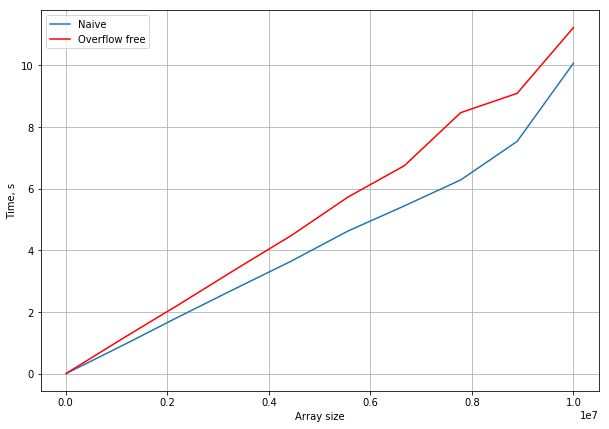

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

plt.plot(n1, time1, label='Naive')
plt.plot(n2, time2, 'r', label='Overflow free')
plt.xlabel('Array size')
plt.ylabel('Time, s')
plt.grid()
plt.legend();

## 4. Выводы

- Реализован алгоритм, вычисляющий норму вектора практически до порога overflow. То есть раннего переполнения почти нет.
- Скорость этого алгоритма сравнима с "наивным".
- При этом алгоритм не зависит от архитектуры, на которой исполняется (может работать и с арифметикой, отличной от IEEE).

### Источники

[1] [Replacing Square Roots by Pythagorean Sums](https://blogs.mathworks.com/images/cleve/moler_morrison.pdf)

[2] [A Portable Fortran Program To Find
the Euclidean Norm of a Vector](http://degiorgi.math.hr/aaa_sem/Float_Norm/p15-blue.pdf)

[3] [https://github.com/compute-io/l2norm](https://github.com/compute-io/l2norm)